# Upbit PPO 트레이딩 노트북

이 노트북은 PPO 기반 트레이딩 에이전트를 구현하고 실험한 코드입니다.
환경 정의, 데이터 전처리, 학습, 평가 순서로 구성되어 있습니다.


## 0⃣ 환경 설정 및 라이브러리 임포트


In [20]:
# 필수 라이브러리 임포트


try:
    import numpy as np
    import pandas as pd
    import requests
    import matplotlib.pyplot as plt
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.preprocessing import StandardScaler
    import seaborn as sns
except ImportError:
    !pip install -q pandas requests matplotlib torch scikit-learn seaborn
    import numpy as np, pandas as pd, requests, matplotlib.pyplot as plt
    import torch, torch.nn as nn, torch.optim as optim
    from sklearn.preprocessing import StandardScaler
    import seaborn as sns

# 추가 유틸리티
import time, math, warnings, os, random, joblib
from datetime import datetime, timedelta, timezone
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from collections import defaultdict, deque
from typing import Optional, Tuple, Dict, List, Any

# 설정
warnings.filterwarnings("ignore")  # 경고 메시지 제거
plt.rcParams['figure.figsize'] = (16, 8)  # 그래프 크기
sns.set_style("whitegrid")  # 시각화 스타일

# 버전 정보 출력
print(f"\n 환경 정보:")
print(f"  - Python: {__import__('sys').version.split()[0]}")
print(f"  - PyTorch: {torch.__version__}")
print(f"  - CUDA: {'사용 가능' if torch.cuda.is_available() else '미사용'}")
print(f"  - NumPy: {np.__version__}")
print(f"  - Pandas: {pd.__version__}")

 모든 라이브러리 임포트 성공

 환경 정보:
  - Python: 3.12.12
  - PyTorch: 2.9.0+cu126
  - CUDA: 사용 가능
  - NumPy: 2.0.2
  - Pandas: 2.2.2


## 1⃣ CFG (전역 설정)


In [ ]:
# 전역 설정 (CFG)


CFG = {
    # ============================================
    # 데이터 수집 설정
    # ============================================
    "market": "KRW-ETH",      # 거래 마켓 (KRW-BTC, KRW-ETH 등)
    "interval": "minute240",         # 캔들 간격 (day, minute240, minute60 등)
    "years": 5,                # 수집할 데이터 기간 (년) 
    "sleep": 0.20,             # API 요청 간 대기 시간 (초)

    # ============================================
    #  실시간 거래 모드 설정 (사용X)
    # ============================================
    "real_time_mode": False,   # True: 실시간 거래 시뮬레이션
    "rolling_window": None,    # 최근 N일 데이터만 사용 (None: 전체)

    # ============================================
    # Train/Eval 분할 설정
    # ============================================
    "use_train_eval_split": True,   # Train/Eval (분할) 권장
    "split_train_ratio": 0.80,      # Train 비율

    # Walk-Forward 검증 (시계열 특화)
    "use_walk_forward": True,       # True: 슬라이딩 윈도우 검증
    "walk_forward_windows": 3,       # 윈도우 개수

    # ============================================
    # 저장 설정
    # ============================================
    "save_enabled": True,            # 모델/데이터 저장 여부
    "data_dir": "./data",            # 데이터 저장 경로
    "model_dir": "./models",         # 모델 저장 경로
    "save_format": "csv",            # 데이터 포맷 (csv, parquet)

    # ============================================
    # 기술적 지표 설정
    # ============================================
    "indicators": {
        "sma": [15, 60, 180],           # 단순이동평균 (일)
        "ema": [36, 78],              # 지수이동평균 (일)
        "rsi": 42,                    # RSI 기간
        "macd": (36, 78, 27),          # MACD (fast, slow, signal)
        "atr": 42,                    # ATR 기간 (변동성)
        "use_pct_return": True,       # 수익률 피처 추가
        "use_log_return": False,      # 로그 수익률 피처
        "normalize_prices": True      # 가격 정규화
    },
    "normalize_features": True,       # StandardScaler 적용

    # ============================================
    # 트레이딩 환경 설정
    # ============================================
    "env": {
        "initial_cash": 1_000_000.0,  # 초기 자본금 (KRW)
        "slippage_bps": 5,            # 슬리피지 (0.05%)
        "fee_bps": 5,                 # 거래 수수료 (0.05%)
        "max_trade_frac": 0.30,       # 최대 거래 비율 (30%)
        "use_risk_adjusted_reward": False,  # 샤프 비율 보상

        # 에피소드 설정
        "episode_length": 504,       #  1년 (=252 거래일) 
        "start_random": True,        #  랜덤 시작 지점
    },

    # ============================================
    # PPO 알고리즘 하이퍼파라미터
    # ============================================
    "ppo": {
        # 기본 설정
        "seed": 43,                   
        "device": "auto",             # auto, cpu, cuda

        # 학습 스케줄
        "total_steps": 800_000,       # 총 학습 스텝 
        "rollout_len": 512,           # 롤아웃 길이 
        "batch_size": 2048,           # 미니배치 크기
        "epochs": 10,                 # PPO 업데이트 에폭

        # 강화학습 파라미터
        "gamma": 0.995,                # 할인율 (미래 보상 가중치)
        "gae_lambda": 0.95,           # GAE λ (advantage 계산)
        "clip_eps": 0.05,             # PPO clipping ε

        # 손실 함수 가중치
        "value_coef": 0.50,           # Value loss 계수
        "entropy_coef": 0.03,         # Entropy bonus 

        # 최적화
        "lr": 3e-4,                   # 학습률
        "max_grad_norm": 1.0,         # 그래디언트 클리핑

        # 신경망 구조
        "hidden": (1024, 1024),         # 히든 레이어 크기

        #  모니터링 및 저장
        "log_interval": 10,           # 로그 출력 간격
        "eval_interval": 20,          # 평가 간격
        "save_best": True,            # 최고 모델 저장

        #  조기 종료
        "early_stopping": True,       # 조기 종료 사용
        "patience": 10,               # 개선 없을 시 대기 횟수
        "min_improvement": 0.01,      # 최소 개선 기준 (1%)

        #  학습률 스케줄링
        "use_lr_scheduler": False,    # 학습률 감소
        "lr_decay_steps": 50000,      # 감소 시작 스텝
        "lr_min": 1e-5,               # 최소 학습률
    },

    # ============================================
    # 앙상블 설정 (고급) 
    # ============================================
    "ensemble": {
        "enabled": False,             # 앙상블 사용
        "n_models": 3,                # 모델 개수
        "seeds": [42, 123, 456],      # 각 모델의 시드
    }
}

# 설정 요약 출력
print(" CFG 설정 완료\n")
print("=" * 50)
print(" 주요 설정 요약")
print("=" * 50)
print(f" 마켓: {CFG['market']} ({CFG['interval']})")
print(f" 데이터: 최근 {CFG['years']}년")
print(f" 초기 자본: {CFG['env']['initial_cash']:,.0f} KRW")
print(f" 총 학습 스텝: {CFG['ppo']['total_steps']:,}")
print(f" 실시간 모드: {'ON' if CFG['real_time_mode'] else 'OFF'}")
print(f" Train/Eval 분할: {'ON' if CFG['use_train_eval_split'] else 'OFF (전체 데이터)'}")
print(f"조기 종료: {'ON (patience={})'.format(CFG['ppo']['patience']) if CFG['ppo']['early_stopping'] else 'OFF'}")
print("=" * 50)

 CFG 설정 완료

 주요 설정 요약
 마켓: KRW-ETH (minute240)
 데이터: 최근 5년
 초기 자본: 1,000,000 KRW
 총 학습 스텝: 800,000
 실시간 모드: OFF
 Train/Eval 분할: ON
조기 종료: ON (patience=10)


## 2⃣ 데이터 수집 및 전처리


In [22]:
# Upbit API를 통한 OHLCV 데이터 수집


def get_ohlcv(market: str, interval: str, years: int, sleep: float) -> pd.DataFrame:
    """
    Upbit에서 OHLCV 데이터 수집

    Args:
        market: 거래 마켓 (예: 'KRW-BTC')
        interval: 캔들 간격 (day, minute240, minute60 등)
        years: 수집할 기간 (년)
        sleep: API 요청 간 대기 시간 (초)

    Returns:
        pd.DataFrame: [time_kst, open, high, low, close, volume]
    """
    # Retry 전략 
    session = requests.Session()
    retry = Retry(
        total=3,                        # 최대 재시도 횟수
        backoff_factor=1.0,             # 지수 백오프
        status_forcelist=[500, 502, 503, 504]  # 재시도할 HTTP 코드
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("http://", adapter)
    session.mount("https://", adapter)

    # Upbit 엔드포인트 형식
    if interval == "day":
        candle_path = "candles/days"  # 일봉
    elif interval.startswith("minute"):
        # 예: "minute60" -> "60"
        unit = interval.replace("minute", "")
        candle_path = f"candles/minutes/{unit}"
    else:
        raise ValueError(f"지원하지 않는 interval: {interval}")

    url = f"https://api.upbit.com/v1/{candle_path}"

    #  수정: 수집 기간 계산 - 모든 datetime을 timezone-aware로 통일
    end_date = datetime.now(timezone.utc)
    start_date = end_date - timedelta(days=365 * years)

    all_data = []
    current_date = end_date
    count_per_request = 200  # Upbit API 최대 캔들 수

    print(f" {market} 데이터 수집 중... (최근 {years}년)")

    # 과거로 거슬러 올라가며 데이터 수집
    while current_date > start_date:
        params = {
            "market": market,
            "to": current_date.strftime("%Y-%m-%d %H:%M:%S"),
            "count": count_per_request
        }

        try:
            response = session.get(url, params=params, timeout=10)
            response.raise_for_status()  # HTTP 오류 발생 시 예외

            data = response.json()
            if not data:
                break  # 더 이상 데이터 없음

            all_data.extend(data)

            oldest_str = data[-1]["candle_date_time_utc"]
            if oldest_str.endswith("Z"):
                oldest_str = oldest_str.replace("Z", "+00:00")

            # fromisoformat으로 timezone-aware datetime 생성
            oldest = datetime.fromisoformat(oldest_str)

            #  만약 naive라면 UTC로 설정
            if oldest.tzinfo is None:
                oldest = oldest.replace(tzinfo=timezone.utc)

            current_date = oldest

            # Rate limiting 준수
            time.sleep(sleep)

        except requests.exceptions.RequestException as e:
            print(f" API 오류: {e}")
            time.sleep(5)  # 오류 시 대기 후 재시도
            continue

    # DataFrame 변환
    df = pd.DataFrame(all_data)

    # UTC - KST 변환
    df["time_kst"] = pd.to_datetime(
        df["candle_date_time_utc"], utc=True
    ).dt.tz_convert("Asia/Seoul")

    # 필요한 컬럼만 선택 및 정렬
    df = df[["time_kst", "opening_price", "high_price",
             "low_price", "trade_price", "candle_acc_trade_volume"]]

    df.columns = ["time_kst", "open", "high", "low", "close", "volume"]
    df = df.sort_values("time_kst").reset_index(drop=True)

    print(f" 수집 완료: {len(df):,}개 캔들 ({df['time_kst'].min()} ~ {df['time_kst'].max()})")

    return df

In [23]:
# 기술적 지표 (Technical Indicators)


def sma(series: pd.Series, window: int) -> pd.Series:
    """단순 이동평균 (Simple Moving Average)"""
    return series.rolling(window, min_periods=window).mean()


def ema(series: pd.Series, span: int) -> pd.Series:
    """지수 이동평균 (Exponential Moving Average)"""
    return series.ewm(span=span, adjust=False, min_periods=span).mean()


def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    """
    상대강도지수 (Relative Strength Index)

    - 0~100 범위
    - 70 이상: 과매수
    - 30 이하: 과매도
    """
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)  # 상승분만
    loss = -delta.where(delta < 0, 0.0)  # 하락분만

    avg_gain = gain.rolling(period, min_periods=period).mean()
    avg_loss = loss.rolling(period, min_periods=period).mean()

    rs = avg_gain / (avg_loss + 1e-10)  # 0으로 나누기 방지
    rsi_val = 100.0 - (100.0 / (1.0 + rs))

    return rsi_val


def macd(series: pd.Series, fast: int = 12, slow: int = 26,
         signal: int = 9) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    MACD (Moving Average Convergence Divergence)

    Returns:
        macd_line: MACD 선 (fast EMA - slow EMA)
        signal_line: Signal 선 (MACD의 EMA)
        histogram: MACD - Signal (매수/매도 신호)
    """
    fast_ema = ema(series, fast)
    slow_ema = ema(series, slow)
    macd_line = fast_ema - slow_ema
    signal_line = ema(macd_line, signal)
    histogram = macd_line - signal_line

    return macd_line, signal_line, histogram


def atr(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """
    ATR (Average True Range) - 변동성 지표

    값이 클수록 변동성이 크고, 작을수록 안정적
    """
    high = df["high"]
    low = df["low"]
    close = df["close"]
    prev_close = close.shift(1)

    # True Range: 3가지 중 최댓값
    # 1) High - Low
    # 2) |High - Previous Close|
    # 3) |Low - Previous Close|
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    # ATR: True Range의 이동평균
    atr_val = tr.rolling(period, min_periods=period).mean()

    return atr_val


def build_features(df: pd.DataFrame, cfg: Dict) -> pd.DataFrame:
    """
    기술적 지표를 계산하여 피처 추가

    Args:
        df: OHLCV 데이터
        cfg: 설정 딕셔너리

    Returns:
        피처가 추가된 DataFrame
    """
    ind = cfg["indicators"]
    feat = df.copy()

    print("\n 기술적 지표 계산 중...")

    # 이동평균
    for window in ind["sma"]:
        feat[f"sma_{window}"] = sma(feat["close"], window)

    for span in ind["ema"]:
        feat[f"ema_{span}"] = ema(feat["close"], span)

    # RSI
    feat["rsi"] = rsi(feat["close"], ind["rsi"])

    # MACD
    macd_line, signal_line, histogram = macd(feat["close"], *ind["macd"])
    feat["macd"] = macd_line
    feat["macd_sig"] = signal_line
    feat["macd_hist"] = histogram

    # ATR (변동성)
    feat["atr"] = atr(feat, ind["atr"])

    # 수익률 피처
    if ind["use_pct_return"]:
        feat["ret1"] = feat["close"].pct_change().fillna(0.0)

    if ind["use_log_return"]:
        feat["logret1"] = np.log(feat["close"]).diff().fillna(0.0)

    # 가격 정규화 (초기 가격 대비)
    if ind["normalize_prices"]:
        feat["close_norm"] = (feat["close"] / feat["close"].iloc[0]) - 1.0

    # NaN 제거 (초기 윈도우 기간)
    feat_clean = feat.dropna().reset_index(drop=True)

    print(f" 피처 생성 완료: {len(feat_clean.columns)}개 컬럼")
    print(f"  - 원본 데이터: {len(df):,}행")
    print(f"  - 정제 후: {len(feat_clean):,}행 (NaN 제거)")

    return feat_clean

In [ ]:
# 데이터 수집 및 전처리 실행


print("\n" + "="*60)
print(" 데이터 수집 및 전처리 시작")
print("="*60)

# 1. OHLCV 데이터 수집
df_raw = get_ohlcv(
    market=CFG["market"],
    interval=CFG["interval"],
    years=CFG["years"],
    sleep=CFG["sleep"]
)

# 2. 기술적 지표 생성
df_features = build_features(df_raw, CFG)

# 3. 실시간 모드: Rolling window 적용 //미사용
if CFG["real_time_mode"] and CFG["rolling_window"] is not None:
    n_keep = CFG["rolling_window"]
    if len(df_features) > n_keep:
        df_features = df_features.iloc[-n_keep:].reset_index(drop=True)
        print(f"\n 실시간 모드: 최근 {n_keep}일 데이터만 사용") 

# 4. 피처 컬럼 분리
base_cols = ["time_kst", "open", "high", "low", "close", "volume"]
feature_cols = [c for c in df_features.columns if c not in base_cols]

print(f"\n 피처 컬럼 ({len(feature_cols)}개):")
print(f"  {', '.join(feature_cols)}")

# 5. Train/Eval 분할
if CFG["use_train_eval_split"]:
    n_train = int(len(df_features) * CFG["split_train_ratio"])
    train_df_raw = df_features.iloc[:n_train].copy()
    eval_df_raw = df_features.iloc[n_train:].copy().reset_index(drop=True)

    print(f"\n 데이터 분할:")
    print(f"  - Train: {len(train_df_raw):,}일 ({train_df_raw['time_kst'].min()} ~ {train_df_raw['time_kst'].max()})")
    print(f"  - Eval:  {len(eval_df_raw):,}일 ({eval_df_raw['time_kst'].min()} ~ {eval_df_raw['time_kst'].max()})")
else:
    train_df_raw = df_features.copy()
    eval_df_raw = None

    print(f"\n 전체 데이터 사용: {len(train_df_raw):,}일")

# 6. 피처 정규화 (StandardScaler)
if CFG.get("normalize_features", True):
    print(f"\n 피처 정규화 (StandardScaler)...")

    scaler = StandardScaler()
    scaler.fit(train_df_raw[feature_cols])

    # Train 데이터 정규화
    train_df = train_df_raw.copy()
    train_df[feature_cols] = scaler.transform(train_df_raw[feature_cols])

    # Eval 데이터 정규화 (같은 scaler 사용)
    if eval_df_raw is not None:
        eval_df = eval_df_raw.copy()
        eval_df[feature_cols] = scaler.transform(eval_df_raw[feature_cols])
    else:
        eval_df = None

    print(f"   정규화 완료 (평균=0, 표준편차=1)")

    # Scaler 저장 (실전 배포용)
    if CFG.get("save_enabled"):
        os.makedirs(CFG["data_dir"], exist_ok=True)
        scaler_path = os.path.join(CFG["data_dir"], "scaler.joblib")
        joblib.dump(scaler, scaler_path)
        print(f"   Scaler 저장: {scaler_path}")
else:
    train_df = train_df_raw
    eval_df = eval_df_raw

print("\n" + "="*60)
print(" 데이터 준비 완료")
print("="*60)
print(f" 최종 데이터셋:")
print(f"  - 전체: {len(df_features):,}일")
print(f"  - Train: {len(train_df):,}일")
if eval_df is not None:
    print(f"  - Eval: {len(eval_df):,}일")
print(f"  - 피처 차원: {len(feature_cols)}")


 데이터 수집 및 전처리 시작
 KRW-ETH 데이터 수집 중... (최근 5년)
 수집 완료: 11,000개 캔들 (2020-11-29 13:00:00+09:00 ~ 2025-12-06 21:00:00+09:00)

 기술적 지표 계산 중...
 피처 생성 완료: 18개 컬럼
  - 원본 데이터: 11,000행
  - 정제 후: 10,821행 (NaN 제거)

 피처 컬럼 (12개):
  sma_15, sma_60, sma_180, ema_36, ema_78, rsi, macd, macd_sig, macd_hist, atr, ret1, close_norm

 데이터 분할:
  - Train: 8,656일 (2020-12-29 09:00:00+09:00 ~ 2024-12-11 01:00:00+09:00)
  - Eval:  2,165일 (2024-12-11 05:00:00+09:00 ~ 2025-12-06 21:00:00+09:00)

 피처 정규화 (StandardScaler)...
   정규화 완료 (평균=0, 표준편차=1)
   Scaler 저장: ./data/scaler.joblib

 데이터 준비 완료
 최종 데이터셋:
  - 전체: 10,821일
  - Train: 8,656일
  - Eval: 2,165일
  - 피처 차원: 12


## 3⃣ 트레이딩 환경 (TradingEnv)


In [ ]:
class TradingEnv:
    """
     Fixed Version 4.1
    - Look-ahead bias removed: Starts at index 1, Obs uses t-1, Trade uses t.
    - Random Start implemented.
    """

    def __init__(self, df, env_cfg, track_trades=False):
        self.df = df.reset_index(drop=True)
        self.init_cash = float(env_cfg["initial_cash"])
        self.slip = float(env_cfg["slippage_bps"]) / 1e4
        self.fee = float(env_cfg["fee_bps"]) / 1e4
        self.max_trade_frac = float(env_cfg["max_trade_frac"])
        self.use_risk_reward = env_cfg.get("use_risk_adjusted_reward", False)

        # Episode config
        self.episode_length = env_cfg.get("episode_length", None)
        self.start_random = env_cfg.get("start_random", False)

        # Data Arrays
        self.close_prices = self.df["close"].values.astype(np.float32)
        self.open_prices = self.df["open"].values.astype(np.float32)

        # Feature Columns
        self.obs_cols = [c for c in self.df.columns
                        if c not in ("time_kst", "open", "high", "low", "close", "volume")]
        self.obs_features_df = self.df[self.obs_cols].values.astype(np.float32)
        self.obs_dim = len(self.obs_cols) + 3

        # Tracking
        self.track_trades = track_trades
        self.trade_history = []
        self.equity_history = deque(maxlen=30)

        self.ptr = 0
        self.end_ptr = len(self.close_prices) - 1

        print(f" TradingEnv Initialized: {len(self.df)} days, {self.obs_dim} dims")

    def _get_obs(self):
        obs_idx = self.ptr - 1

        # Safety check
        if obs_idx < 0: obs_idx = 0

        tech = self.obs_features_df[obs_idx]

        # Portfolio state
        # Valuation using PREVIOUS close (known info)
        price = self.close_prices[obs_idx]
        pos_val = self.eth_held * price
        equity = self.cash_held + pos_val
        pos_ratio = pos_val / equity if equity > 0 else 0.0

        portfolio = np.array([
            self.cash_held / self.init_cash,
            pos_val / self.init_cash,
            pos_ratio
        ], dtype=np.float32)

        return np.concatenate([tech, portfolio]).astype(np.float32)

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        # Implement Random Start
        if self.start_random and self.episode_length is not None:
            max_start = len(self.close_prices) - self.episode_length - 1
            if max_start > 1:
                self.ptr = random.randint(1, max_start)
                self.end_ptr = self.ptr + self.episode_length
            else:
                self.ptr = 1
                self.end_ptr = len(self.close_prices) - 1
        else:
            self.ptr = 1
            self.end_ptr = len(self.close_prices) - 1

        self.cash_held = self.init_cash
        self.eth_held = 0.0
        self.start_equity = self.init_cash
        self.equity_history.clear()
        self.equity_history.append(self.init_cash)

        if self.track_trades:
            self.trade_history = []

        return self._get_obs(), {}

    def step(self, action):
        # 1. Define Action (Buy/Sell/Hold)
        trade_frac = float(np.clip(action, -1.0, 1.0)) * self.max_trade_frac

        # 2. Execution: At OPEN price of current day (ptr)
        exec_price = float(self.open_prices[self.ptr])

        # Calculate costs
        buy_price = exec_price * (1.0 + self.slip + self.fee)
        sell_price = exec_price * (1.0 - self.slip - self.fee)

        # Record previous equity 
        prev_price = float(self.close_prices[self.ptr - 1])
        prev_equity = self.cash_held + self.eth_held * prev_price

        # 3. Execute Trade
        trade_type = None
        if trade_frac > 0.01:  # Buy
            krw_to_spend = self.cash_held * trade_frac
            eth_bought = krw_to_spend / max(buy_price, 1e-9)
            self.cash_held -= eth_bought * buy_price
            self.eth_held += eth_bought
            trade_type = 'buy'
        elif trade_frac < -0.01:  # Sell
            eth_to_sell = self.eth_held * (-trade_frac)
            krw_received = eth_to_sell * sell_price
            self.eth_held -= eth_to_sell
            self.cash_held += krw_received
            trade_type = 'sell'

        # 4. Calculate New Equity 
        current_price = self.close_prices[self.ptr]
        current_equity = self.cash_held + self.eth_held * current_price
        self.equity_history.append(current_equity)

        # 5. Compute Reward (Percentage Change)
        if self.use_risk_reward and len(self.equity_history) > 10:
            # Simple Sharpe approximation
            rets = np.diff(list(self.equity_history)) / np.array(list(self.equity_history)[:-1])
            sharpe = rets.mean() / (rets.std() + 1e-8)
            reward = sharpe * 0.1
        else:
            # Daily Return
            reward = (current_equity - prev_equity) / (self.start_equity + 1e-8)

        # Log Trade
        if self.track_trades and trade_type is not None:
            self.trade_history.append({
                "step": self.ptr,
                "action": trade_type,
                "trade_frac": trade_frac,
                "price": exec_price,
                "equity": current_equity
            })

        # 6. Advance Step
        self.ptr += 1
        done = bool(self.ptr >= self.end_ptr)

        return self._get_obs(), float(reward), done, done, {"equity": float(current_equity)}

## 4⃣ PPO 알고리즘 구현


In [ ]:
# 유틸리티 함수


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



def get_device(name: str) -> torch.device:
    """
    디바이스 선택

    Args:
        name: 'auto', 'cpu', 'cuda'
    """
    if name == "cpu":
        return torch.device("cpu")
    elif name == "cuda":
        if not torch.cuda.is_available():
            print(" CUDA 미지원, CPU 사용")
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:  # auto
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")


print(" 유틸리티 함수 정의 완료")

 유틸리티 함수 정의 완료


In [ ]:
# 신경망 모델


class MLP(nn.Module):
    """Multi-Layer Perceptron"""

    def __init__(self, in_dim: int, out_dim: int, hidden: Tuple[int, ...]):
        """
        Args:
            in_dim: 입력 차원
            out_dim: 출력 차원
            hidden: 히든 레이어 크기 (예: (128, 128))
        """
        super().__init__()

        layers = []
        last_dim = in_dim

        # 히든 레이어 생성
        for h_dim in hidden:
            layers.append(nn.Linear(last_dim, h_dim))
            layers.append(nn.ReLU())
            last_dim = h_dim

        # 출력 레이어
        layers.append(nn.Linear(last_dim, out_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class GaussianPolicy(nn.Module):
    """
    가우시안 정책

    행동 분포: N(μ, σ²)
    - μ(s): MLP 출력
    - σ: 학습 가능한 파라미터
    """

    def __init__(self, obs_dim: int, act_dim: int, hidden: Tuple[int, ...]):
        super().__init__()

        # 평균 네트워크
        self.mu_net = MLP(obs_dim, act_dim, hidden)

        # 로그 표준편차 (학습 가능)
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            (평균, 표준편차)
        """
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std).expand_as(mu)
        return mu, std

    def sample(self, obs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        
        Returns:
            (행동, 로그 확률)
        """
        mu, std = self(obs)
        dist = torch.distributions.Normal(mu, std)

        # Reparameterization: a = μ + σ * ε, ε ~ N(0, 1)
        action = dist.rsample()
        log_prob = dist.log_prob(action).sum(-1, keepdim=True)

        return action, log_prob

    def log_prob(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """
        주어진 행동의 로그 확률 계산
        """
        mu, std = self(obs)
        dist = torch.distributions.Normal(mu, std)
        return dist.log_prob(action).sum(-1, keepdim=True)


class ValueNetwork(nn.Module):
    """V(s)"""

    def __init__(self, obs_dim: int, hidden: Tuple[int, ...]):
        super().__init__()
        self.net = MLP(obs_dim, 1, hidden)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.net(obs)


print(" 신경망 모델 정의 완료")
print("  - GaussianPolicy: 연속 행동 샘플링")
print("  - ValueNetwork: 상태 가치 추정")

 신경망 모델 정의 완료
  - GaussianPolicy: 연속 행동 샘플링
  - ValueNetwork: 상태 가치 추정


In [ ]:
# PPO 알고리즘 구현


def compute_gae(
    rewards: np.ndarray,
    values: np.ndarray,
    dones: np.ndarray,
    gamma: float,
    lam: float
) -> Tuple[np.ndarray, np.ndarray]:
    """
    GAE (Generalized Advantage Estimation) 계산

    Args:
        rewards: 보상 배열 [T]
        values: 가치 추정 [T]
        dones: 종료 플래그 [T]
        gamma: 할인율
        lam: GAE λ

    Returns:
        (advantages, returns)
    """
    T = len(rewards)
    advantages = np.zeros(T, dtype=np.float32)
    last_gae = 0.0

    # 역방향으로 GAE 계산
    for t in reversed(range(T)):
        if t == T - 1:
            next_value = 0.0
        else:
            next_value = values[t + 1]

        # TD error: δ = r + γ*V(s') - V(s)
        delta = rewards[t] + gamma * next_value * (1 - dones[t]) - values[t]

        # GAE: A = δ + γλ * A(t+1)
        advantages[t] = last_gae = delta + gamma * lam * (1 - dones[t]) * last_gae

    # Returns: R = A + V
    returns = advantages + values

    return advantages, returns


def ppo_update(
    policy: GaussianPolicy,
    value_net: ValueNetwork,
    optimizer: optim.Optimizer,
    obs: torch.Tensor,
    actions: torch.Tensor,
    old_log_probs: torch.Tensor,
    advantages: torch.Tensor,
    returns: torch.Tensor,
    clip_eps: float,
    value_coef: float,
    entropy_coef: float,
    max_grad_norm: float
) -> Dict[str, float]:
    """
    PPO 손실 계산 및 업데이트

    Returns:
        손실 통계 딕셔너리
    """
    # 현재 정책의 로그 확률
    new_log_probs = policy.log_prob(obs, actions)

    # Ratio: π_new / π_old
    ratio = torch.exp(new_log_probs - old_log_probs)

    # Clipped surrogate objective
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * advantages
    policy_loss = -torch.min(surr1, surr2).mean()

    # Value loss (MSE)
    values = value_net(obs)
    value_loss = ((values - returns) ** 2).mean()

    # Entropy bonus 
    mu, std = policy(obs)
    dist = torch.distributions.Normal(mu, std)
    entropy = dist.entropy().mean()

    # 총 손실
    loss = policy_loss + value_coef * value_loss - entropy_coef * entropy

    # 역전파
    optimizer.zero_grad()
    loss.backward()

    # 그래디언트 클리핑
    grad_norm = nn.utils.clip_grad_norm_(
        list(policy.parameters()) + list(value_net.parameters()),
        max_grad_norm
    )

    optimizer.step()

    return {
        "loss": loss.item(),
        "policy_loss": policy_loss.item(),
        "value_loss": value_loss.item(),
        "entropy": entropy.item(),
        "grad_norm": grad_norm.item()
    }


print(" PPO 알고리즘 함수 정의 완료")
print("  - GAE: Advantage 계산")
print("  - ppo_update: Clipped objective 최적화")

 PPO 알고리즘 함수 정의 완료
  - GAE: Advantage 계산
  - ppo_update: Clipped objective 최적화


## 5⃣ 학습 루프


In [ ]:
# PPO 학습 메인 함수


def train_ppo(train_env: TradingEnv, eval_env: Optional[TradingEnv], cfg: Dict) -> Tuple:
    """
    PPO 알고리즘으로 트레이딩 에이전트 학습

    Args:
        train_env: 학습 환경
        eval_env: 평가 환경 (None 가능)
        cfg: 전역 설정

    Returns:
        (policy, value_net, training_log)
    """
    ppo_cfg = cfg["ppo"]

    # 시드 설정
    set_seed(ppo_cfg["seed"])
    device = get_device(ppo_cfg["device"])

    print(f"\n{'='*60}")
    print(f" PPO 학습 시작")
    print(f"{'='*60}")
    print(f" 디바이스: {device}")
    print(f" 관측 차원: {train_env.obs_dim}")
    print(f" 총 스텝: {ppo_cfg['total_steps']:,}")
    print(f" 배치 크기: {ppo_cfg['batch_size']}")
    print(f"{'='*60}\n")

    # 모델 초기화
    policy = GaussianPolicy(
        obs_dim=train_env.obs_dim,
        act_dim=1,  # 단일 연속 행동
        hidden=ppo_cfg["hidden"]
    ).to(device)

    value_net = ValueNetwork(
        obs_dim=train_env.obs_dim,
        hidden=ppo_cfg["hidden"]
    ).to(device)

    # 옵티마이저
    optimizer = optim.Adam(
        list(policy.parameters()) + list(value_net.parameters()),
        lr=ppo_cfg["lr"]
    )

    # 학습률 스케줄러
    if ppo_cfg.get("use_lr_scheduler", False):
        scheduler = optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=1.0,
            end_factor=ppo_cfg["lr_min"] / ppo_cfg["lr"],
            total_iters=ppo_cfg["lr_decay_steps"]
        )
    else:
        scheduler = None

    # 학습 로그
    training_log = {
        "steps": [],
        "episode_rewards": [],
        "episode_lengths": [],
        "losses": [],
        "eval_returns": [],
        "eval_sharpe": [],
        "best_eval_return": -np.inf
    }

    # 조기 종료 변수
    patience_counter = 0
    best_eval_metric = -np.inf

    # === 메인 학습 루프 ===
    total_steps = 0
    obs, _ = train_env.reset(seed=ppo_cfg["seed"])
    episode_reward = 0.0
    episode_length = 0

    while total_steps < ppo_cfg["total_steps"]:
        # === 롤아웃 ===
        rollout_obs = []
        rollout_actions = []
        rollout_log_probs = []
        rollout_rewards = []
        rollout_values = []
        rollout_dones = []

        policy.eval()
        value_net.eval()

        with torch.no_grad():
            for _ in range(ppo_cfg["rollout_len"]):
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)

                # 행동 샘플링
                action, log_prob = policy.sample(obs_tensor)
                value = value_net(obs_tensor)

                action_np = action.squeeze().cpu().numpy()

                # 환경 스텝
                next_obs, reward, done, _, info = train_env.step(action_np)

                # 저장
                rollout_obs.append(obs)
                rollout_actions.append(action_np)
                rollout_log_probs.append(log_prob.item())
                rollout_rewards.append(reward)
                rollout_values.append(value.item())
                rollout_dones.append(float(done))

                episode_reward += reward
                episode_length += 1
                total_steps += 1

                obs = next_obs

                if done:
                    training_log["episode_rewards"].append(episode_reward)
                    training_log["episode_lengths"].append(episode_length)
                    obs, _ = train_env.reset()
                    episode_reward = 0.0
                    episode_length = 0

                if total_steps >= ppo_cfg["total_steps"]:
                    break

        # === GAE 계산 ===
        rollout_obs = np.array(rollout_obs, dtype=np.float32)
        rollout_actions = np.array(rollout_actions, dtype=np.float32).reshape(-1, 1)
        rollout_log_probs = np.array(rollout_log_probs, dtype=np.float32).reshape(-1, 1)
        rollout_rewards = np.array(rollout_rewards, dtype=np.float32)
        rollout_values = np.array(rollout_values, dtype=np.float32)
        rollout_dones = np.array(rollout_dones, dtype=np.float32)

        advantages, returns = compute_gae(
            rollout_rewards,
            rollout_values,
            rollout_dones,
            ppo_cfg["gamma"],
            ppo_cfg["gae_lambda"]
        )

        # Normalize advantages 
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # === PPO 업데이트 ===
        policy.train()
        value_net.train()

        # 텐서 변환
        obs_t = torch.FloatTensor(rollout_obs).to(device)
        actions_t = torch.FloatTensor(rollout_actions).to(device)
        old_log_probs_t = torch.FloatTensor(rollout_log_probs).to(device)
        advantages_t = torch.FloatTensor(advantages).unsqueeze(-1).to(device)
        returns_t = torch.FloatTensor(returns).unsqueeze(-1).to(device)

        # 미니배치 학습
        batch_size = ppo_cfg["batch_size"]
        n_samples = len(rollout_obs)
        epoch_losses = []

        for _ in range(ppo_cfg["epochs"]):
            indices = np.random.permutation(n_samples)

            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                batch_idx = indices[start:end]

                stats = ppo_update(
                    policy, value_net, optimizer,
                    obs_t[batch_idx],
                    actions_t[batch_idx],
                    old_log_probs_t[batch_idx],
                    advantages_t[batch_idx],
                    returns_t[batch_idx],
                    ppo_cfg["clip_eps"],
                    ppo_cfg["value_coef"],
                    ppo_cfg["entropy_coef"],
                    ppo_cfg["max_grad_norm"]
                )

                epoch_losses.append(stats["loss"])

        # 학습률 스케줄링
        if scheduler is not None:
            scheduler.step()

        # 로그 기록
        training_log["steps"].append(total_steps)
        training_log["losses"].append(np.mean(epoch_losses))

        # === 로그 출력 ===
        if len(training_log["steps"]) % ppo_cfg["log_interval"] == 0:
            recent_rewards = training_log["episode_rewards"][-10:]
            avg_reward = np.mean(recent_rewards) if recent_rewards else 0.0

            print(f"[Step {total_steps:>7,}] "
                  f"Reward: {avg_reward:>8.2f} | "
                  f"Loss: {training_log['losses'][-1]:.4f} | "
                  f"Episodes: {len(training_log['episode_rewards'])}")

        # === 평가 ===
        if len(training_log["steps"]) % ppo_cfg["eval_interval"] == 0:
            if eval_env is not None:
                eval_return, eval_sharpe = evaluate_policy(
                    policy, eval_env, device, n_episodes=1
                )
            else:
                # Eval 환경 없으면 Train 환경에서 평가
                eval_return, eval_sharpe = evaluate_policy(
                    policy, train_env, device, n_episodes=1
                )

            training_log["eval_returns"].append(eval_return)
            training_log["eval_sharpe"].append(eval_sharpe)

            print(f"   Eval | Return: {eval_return:>10,.0f} KRW | Sharpe: {eval_sharpe:>6.3f}")

            # 최고 모델 저장
            if ppo_cfg["save_best"] and eval_return > training_log["best_eval_return"]:
                training_log["best_eval_return"] = eval_return

                if cfg.get("save_enabled"):
                    os.makedirs(cfg["model_dir"], exist_ok=True)
                    torch.save({
                        "policy": policy.state_dict(),
                        "value_net": value_net.state_dict(),
                        "eval_return": eval_return,
                        "step": total_steps
                    }, os.path.join(cfg["model_dir"], "best_model.pt"))
                    print(f"   최고 모델 저장 완료")

            # 조기 종료 체크
            if ppo_cfg["early_stopping"]:
              if best_eval_metric == -np.inf:
                best_eval_metric = eval_return
                patience_counter = 0
              else:
                improvement = (eval_return - best_eval_metric) / (abs(best_eval_metric) + 1e-8)

                if improvement > ppo_cfg["min_improvement"]:
                    best_eval_metric = eval_return
                    patience_counter = 0
                else:
                    patience_counter += 1

              if patience_counter >= ppo_cfg["patience"]:
                    print(f"\n 조기 종료: {ppo_cfg['patience']}번 연속 개선 없음")
                    break

    print(f"\n{'='*60}")
    print(f" 학습 완료")
    print(f"{'='*60}")
    print(f" 총 에피소드: {len(training_log['episode_rewards'])}")
    print(f" 최고 Eval Return: {training_log['best_eval_return']:,.0f} KRW")

    return policy, value_net, training_log


def evaluate_policy(
    policy: GaussianPolicy,
    env: TradingEnv,
    device: torch.device,
    n_episodes: int = 1
) -> Tuple[float, float]:
    """
    정책 평가

    Returns:
        (평균 수익, 평균 샤프 비율)
    """
    policy.eval()

    returns = []
    sharpes = []

    with torch.no_grad():
        for _ in range(n_episodes):
            obs, _ = env.reset()
            equity_curve = [env.init_cash]
            done = False

            while not done:
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                mu, _ = policy(obs_tensor)
                action = mu.squeeze().cpu().numpy()

                obs, reward, done, _, info = env.step(action)
                equity_curve.append(info["equity"])

            final_equity = equity_curve[-1]
            total_return = final_equity - env.init_cash
            returns.append(total_return)

            # 샤프 비율 계산
            equity_array = np.array(equity_curve)
            rets = np.diff(equity_array) / equity_array[:-1]
            sharpe = rets.mean() / (rets.std() + 1e-8) * np.sqrt(252)
            sharpes.append(sharpe)

    return np.mean(returns), np.mean(sharpes)


print(" 학습 함수 정의 완료")

 학습 함수 정의 완료


In [ ]:
# 학습 실행


# 환경 생성
print("\n 트레이딩 환경 생성 중...")

train_env = TradingEnv(train_df, CFG["env"], track_trades=False)
print(f"   Train 환경: {len(train_df)}일")

if eval_df is not None:
    eval_env = TradingEnv(eval_df, CFG["env"], track_trades=False)
    print(f"   Eval 환경: {len(eval_df)}일")
else:
    eval_env = None
    print(f" -- Eval 환경 없음 (Train 데이터로 평가)")

# 학습 시작
policy, value_net, training_log = train_ppo(train_env, eval_env, CFG)


 트레이딩 환경 생성 중...
 TradingEnv Initialized: 8656 days, 15 dims
   Train 환경: 8656일
 TradingEnv Initialized: 2165 days, 15 dims
   Eval 환경: 2165일

 PPO 학습 시작
 디바이스: cuda
 관측 차원: 15
 총 스텝: 800,000
 배치 크기: 2048

[Step   5,120] Reward:     0.04 | Loss: -0.0457 | Episodes: 10
[Step  10,240] Reward:     0.06 | Loss: -0.0442 | Episodes: 20
   Eval | Return:     17,052 KRW | Sharpe:  0.907
   최고 모델 저장 완료
[Step  15,360] Reward:    -0.03 | Loss: -0.0465 | Episodes: 30
[Step  20,480] Reward:     0.11 | Loss: -0.0476 | Episodes: 40
   Eval | Return:    293,709 KRW | Sharpe:  1.723
   최고 모델 저장 완료
[Step  25,600] Reward:     0.06 | Loss: -0.0479 | Episodes: 50
[Step  30,720] Reward:     0.32 | Loss: -0.0479 | Episodes: 60
   Eval | Return:    288,558 KRW | Sharpe:  0.799
[Step  35,840] Reward:     0.05 | Loss: -0.0467 | Episodes: 71
[Step  40,960] Reward:     0.01 | Loss: -0.0472 | Episodes: 81
   Eval | Return:       -812 KRW | Sharpe: -0.868
[Step  46,080] Reward:    -0.05 | Loss: -0.0475 | Episodes:

## 6⃣ 최종 평가 및 시각화


In [31]:
# 최종 백테스트 및 성능 분석


def backtest_policy(
    policy: GaussianPolicy,
    env: TradingEnv,
    device: torch.device
) -> Dict[str, Any]:
    """
    학습된 정책으로 백테스트

    Returns:
        성능 메트릭 및 거래 이력
    """
    policy.eval()

    obs, _ = env.reset()
    equity_curve = [env.init_cash]
    actions = []
    done = False

    with torch.no_grad():
        while not done:
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            mu, _ = policy(obs_tensor)
            action = mu.squeeze().cpu().numpy()

            actions.append(float(action))
            obs, reward, done, _, info = env.step(action)
            equity_curve.append(info["equity"])

    # 성능 메트릭 계산
    equity_array = np.array(equity_curve)
    returns = np.diff(equity_array) / equity_array[:-1]

    total_return = (equity_array[-1] / equity_array[0] - 1) * 100
    sharpe = returns.mean() / (returns.std() + 1e-8) * np.sqrt(252)

    # MDD (Maximum Drawdown)
    cummax = np.maximum.accumulate(equity_array)
    drawdown = (cummax - equity_array) / cummax * 100
    mdd = drawdown.max()

    # Win rate
    positive_returns = returns[returns > 0]
    win_rate = len(positive_returns) / len(returns) * 100 if len(returns) > 0 else 0

    # CAGR
    n_days = len(equity_curve)
    cagr = (equity_array[-1] / equity_array[0]) ** (252 / n_days) - 1
    cagr *= 100

    return {
        "equities": equity_curve,
        "actions": actions,
        "metrics": {
            "Total Return": total_return,
            "CAGR": cagr,
            "Sharpe": sharpe,
            "MDD": mdd,
            "Win Rate": win_rate,
            "Total Trades": len([a for a in actions if abs(a) > 0.1])
        }
    }


def buy_and_hold_benchmark(env: TradingEnv) -> Dict[str, Any]:
    """
    Buy & Hold 벤치마크
    """
    obs, _ = env.reset()

    # 첫 시점에 전량 매수
    obs, _, _, _, _ = env.step(1.0)

    equity_curve = [env.init_cash]
    done = False

    while not done:
        obs, _, done, _, info = env.step(0.0)  # 홀드
        equity_curve.append(info["equity"])

    equity_array = np.array(equity_curve)
    returns = np.diff(equity_array) / equity_array[:-1]
    total_return = (equity_array[-1] / equity_array[0] - 1) * 100
    sharpe = returns.mean() / (returns.std() + 1e-8) * np.sqrt(252)

    return {
        "equity_curve": equity_curve,
        "total_return": total_return,
        "sharpe": sharpe
    }


print("\n" + "="*60)
print(" 최종 백테스트 실행")
print("="*60)

# PPO 모델 평가
device = get_device(CFG["ppo"]["device"])

test_df = eval_df if eval_df is not None else train_df

test_env_cfg = {**CFG["env"], "episode_length": None, "start_random": False}
test_env = TradingEnv(test_df, test_env_cfg, track_trades=True)
model_results = backtest_policy(policy, test_env, device)

print("\n PPO 모델 성능:")
for key, value in model_results["metrics"].items():
    print(f"  - {key}: {value:.2f}%" if "Rate" in key or "Return" in key
          else f"  - {key}: {value:.4f}" if "Sharpe" in key
          else f"  - {key}: {value:.2f}")

# Buy & Hold 벤치마크
bh_env_cfg = {**CFG["env"], "max_trade_frac": 1.0, "episode_length": None, "start_random": False}
bh_env = TradingEnv(test_df, bh_env_cfg, track_trades=False)
bh_results = buy_and_hold_benchmark(bh_env)

print("\n Buy & Hold 벤치마크:")
print(f"  - Total Return: {bh_results['total_return']:.2f}%")
print(f"  - Sharpe: {bh_results['sharpe']:.4f}")

# 비교
model_ret = model_results["metrics"]["Total Return"]
bh_ret = bh_results["total_return"]
diff = model_ret - bh_ret

print("\n 성능 비교:")
print(f"  - PPO vs BH: {diff:+.2f}%p")
if diff > 0:
    print(f"   PPO 승리! ({abs(diff):.2f}%p 우위)")
else:
    print(f"   BH 승리... ({abs(diff):.2f}%p 열위)")


 최종 백테스트 실행
 TradingEnv Initialized: 2165 days, 15 dims

 PPO 모델 성능:
  - Total Return: 27.73%
  - CAGR: 2.89
  - Sharpe: 0.4235
  - MDD: 12.25
  - Win Rate: 13.82%
  - Total Trades: 2130.00
 TradingEnv Initialized: 2165 days, 15 dims

 Buy & Hold 벤치마크:
  - Total Return: -12.50%
  - Sharpe: 0.0412

 성능 비교:
  - PPO vs BH: +40.23%p
   PPO 승리! (40.23%p 우위)


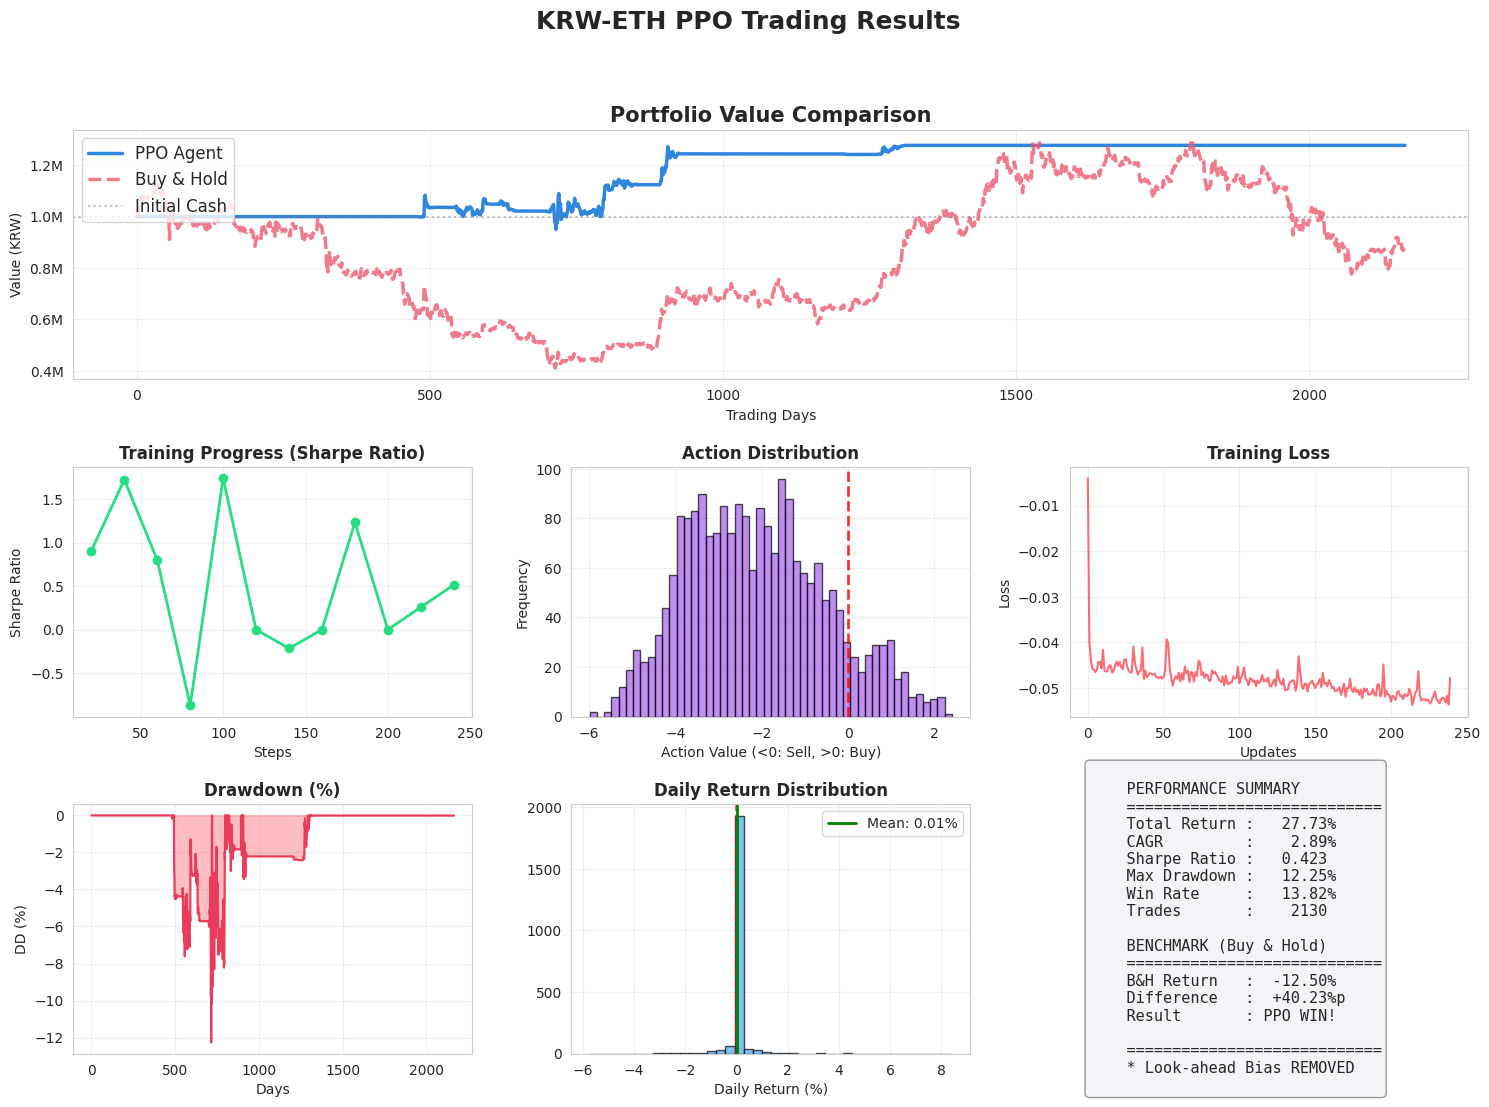

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

# 스타일 설정
plt.rcParams['figure.figsize'] = (18, 12)
sns.set_style("whitegrid")

def plot_results_final(model_results, bh_results, training_log, cfg):
    """
    최종 결과 시각화 함수 (영어 라벨 적용)
    """
    # 1. 캔버스 초기화
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.25)

    # Portfolio Value (PPO vs Buy & Hold)

    ax1 = fig.add_subplot(gs[0, :])

    # 데이터 추출
    ppo_equity = model_results['equities']
    bh_equity = bh_results['equity_curve']

    ax1.plot(ppo_equity, linewidth=2.5, label='PPO Agent', color='#2E86DE')
    ax1.plot(bh_equity, linewidth=2.5, label='Buy & Hold', color='#EE5A6F', linestyle='--', alpha=0.8)
    ax1.axhline(y=cfg['env']['initial_cash'], color='gray', linestyle=':', alpha=0.5, label='Initial Cash')

    ax1.set_title('Portfolio Value Comparison', fontsize=15, fontweight='bold')
    ax1.set_xlabel('Trading Days')
    ax1.set_ylabel('Value (KRW)')
    ax1.legend(loc='upper left', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Y축 단위: 백만
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

    # 2. Training Metric (Sharpe Ratio)

    if training_log['eval_sharpe']:
        ax2 = fig.add_subplot(gs[1, 0])
        eval_interval = cfg['ppo']['eval_interval']
        steps = np.arange(1, len(training_log['eval_sharpe']) + 1) * eval_interval

        ax2.plot(steps, training_log['eval_sharpe'], 'o-', color='#26DE81', linewidth=2)
        ax2.set_title('Training Progress (Sharpe Ratio)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('Sharpe Ratio')
        ax2.grid(True, alpha=0.3)

    # 3. Action Distribution

    ax3 = fig.add_subplot(gs[1, 1])
    actions = model_results['actions']

    ax3.hist(actions, bins=50, alpha=0.7, color='#A55EEA', edgecolor='black')
    ax3.axvline(x=0, color='red', linestyle='--', alpha=0.8, linewidth=2)

    ax3.set_title('Action Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Action Value (<0: Sell, >0: Buy)')
    ax3.set_ylabel('Frequency')
    ax3.grid(True, alpha=0.3)

    # 4. Training Loss

    if training_log['losses']:
        ax4 = fig.add_subplot(gs[1, 2])
        ax4.plot(training_log['losses'], color='#FC5C65', linewidth=1.5, alpha=0.9)
        ax4.set_title('Training Loss', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Updates')
        ax4.set_ylabel('Loss')
        ax4.grid(True, alpha=0.3)

    # 5. Drawdown Analysis

    ax5 = fig.add_subplot(gs[2, 0])
    equity_arr = np.array(ppo_equity)
    cummax = np.maximum.accumulate(equity_arr)
    drawdown = (cummax - equity_arr) / cummax * 100

    ax5.fill_between(range(len(drawdown)), 0, -drawdown, color='#FC5C65', alpha=0.4)
    ax5.plot(-drawdown, color='#EB3B5A', linewidth=1.5)

    ax5.set_title('Drawdown (%)', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Days')
    ax5.set_ylabel('DD (%)')
    ax5.grid(True, alpha=0.3)

    # 6. Daily Returns Histogram

    ax6 = fig.add_subplot(gs[2, 1])
    daily_rets = np.diff(equity_arr) / equity_arr[:-1] * 100

    ax6.hist(daily_rets, bins=40, alpha=0.7, color='#45AAF2', edgecolor='black')
    ax6.axvline(x=0, color='red', linestyle='--', alpha=0.6)
    ax6.axvline(x=daily_rets.mean(), color='green', linestyle='-', linewidth=2,
                label=f'Mean: {daily_rets.mean():.2f}%')

    ax6.set_title('Daily Return Distribution', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Daily Return (%)')
    ax6.legend(loc='upper right')
    ax6.grid(True, alpha=0.3)

    # 7. Summary Metrics Table

    ax7 = fig.add_subplot(gs[2, 2])
    ax7.axis('off')

    metrics = model_results['metrics']
    model_final = metrics['Total Return']
    bh_final = bh_results['total_return']
    diff = model_final - bh_final

    summary_text = f"""
    PERFORMANCE SUMMARY
    {'='*28}
    Total Return : {model_final:>7.2f}%
    CAGR         : {metrics['CAGR']:>7.2f}%
    Sharpe Ratio : {metrics['Sharpe']:>7.3f}
    Max Drawdown : {metrics['MDD']:>7.2f}%
    Win Rate     : {metrics['Win Rate']:>7.2f}%
    Trades       : {metrics['Total Trades']:>7}

    BENCHMARK (Buy & Hold)
    {'='*28}
    B&H Return   : {bh_final:>7.2f}%
    Difference   : {diff:>+7.2f}%p
    Result       : {'PPO WIN!' if diff > 0 else 'B&H WIN'}

    {'='*28}
    * Look-ahead Bias REMOVED
    """

    ax7.text(0.05, 0.5, summary_text, fontsize=11, verticalalignment='center',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='#f1f2f6', edgecolor='gray', alpha=0.8))

    plt.suptitle(f"{cfg['market']} PPO Trading Results", fontsize=18, fontweight='bold')
    plt.show()

# 함수 실행
plot_results_final(model_results, bh_results, training_log, CFG)

## 7⃣ 모델 저장

---




In [33]:
#최종 모델 저장

if CFG.get("save_enabled"):
    print("\n 모델 저장")

    os.makedirs(CFG["model_dir"], exist_ok=True)

    # 최종 모델 저장
    final_model_path = os.path.join(CFG["model_dir"], "final_model.pt")
    torch.save({
        "policy": policy.state_dict(),
        "value_net": value_net.state_dict(),
        "config": CFG,
        "metrics": model_results["metrics"],
        "training_log": training_log
    }, final_model_path)

    print(f" - 최종 모델: {final_model_path}")

    # 거래 이력 저장
    if test_env.track_trades and test_env.trade_history:
        trades_df = pd.DataFrame(test_env.trade_history)
        trades_path = os.path.join(CFG["data_dir"], "trade_history.csv")
        trades_df.to_csv(trades_path, index=False)
        print(f" - 거래 이력: {trades_path}")

    print("\n 저장 완료")
else:
    print("\n 저장 비활성화 (CFG['save_enabled'] = False)")


 모델 저장
 - 최종 모델: ./models/final_model.pt
 - 거래 이력: ./data/trade_history.csv

 저장 완료


총 트레이드 수: 2153


,step,action,trade_frac,price,equity
0,1,sell,-0.3,5195000.0,1000000.0
1,2,sell,-0.3,5216000.0,1000000.0
2,3,sell,-0.3,5197000.0,1000000.0
3,4,sell,-0.3,5297000.0,1000000.0
4,5,sell,-0.3,5379000.0,1000000.0


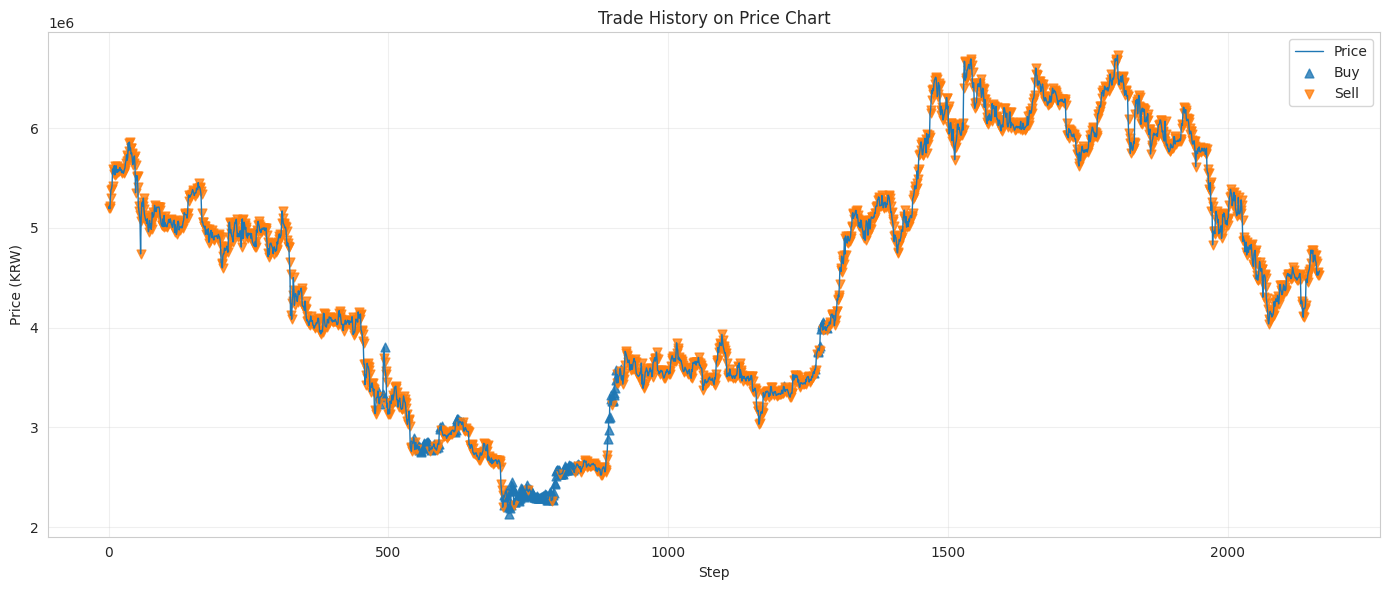

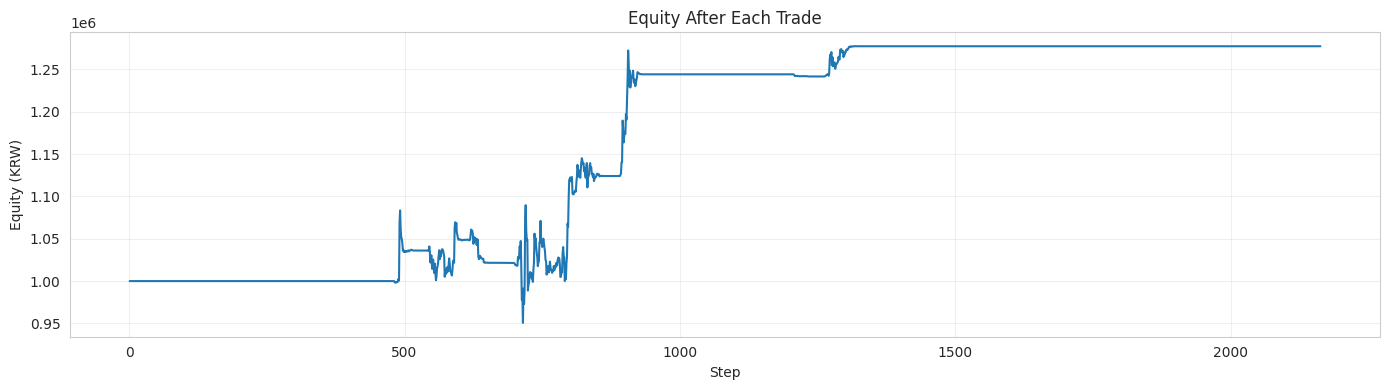

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

env_log = test_env

trades_df = pd.DataFrame(env_log.trade_history)

print(f"총 트레이드 수: {len(trades_df)}")
display(trades_df.head())

# 가격 시계열
price_series = env_log.df["close"].reset_index(drop=True)

buys  = trades_df[trades_df["action"] == "buy"]
sells = trades_df[trades_df["action"] == "sell"]

fig, ax = plt.subplots(figsize=(14, 6))

# price
ax.plot(price_series.index, price_series.values, label="Price", linewidth=1)

# buy, sell point
ax.scatter(buys["step"],  buys["price"],  marker="^", s=40, label="Buy",  alpha=0.8)
ax.scatter(sells["step"], sells["price"], marker="v", s=40, label="Sell", alpha=0.8)

ax.set_title("Trade History on Price Chart")
ax.set_xlabel("Step")
ax.set_ylabel("Price (KRW)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))

# equity
ax.plot(trades_df["step"], trades_df["equity"], linewidth=1.5)

ax.set_title("Equity After Each Trade")
ax.set_xlabel("Step")
ax.set_ylabel("Equity (KRW)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



